AMAZON ALEXA PERFORMANCE PREDICTION

Author: Shivani Grover
    
Date: 2/11/2020

In [2]:
#### Importing the required libraries 

import pandas as pd
import numpy as np
import json
import requests
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from sklearn.naive_bayes import MultinomialNB
from  sklearn.metrics  import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
###### Loading the Alexa transcript file
with open('C:/Users/garis/Documents/attachments (1)/alexa-prize-topical-chat-dataset-master/conversations/train.json', 'r') as myfile:
    data=myfile.read()
train = json.loads(data)
with open('C:/Users/garis/Documents/attachments (1)/alexa-prize-topical-chat-dataset-master/conversations/test_rare.json', 'r') as myfile:
    data_test=myfile.read()
test = json.loads(data_test)

In [11]:
#function to read json objects
def extract_values(obj, key):
    """Pull all values of specified key from nested JSON."""
    arr = []

    def extract(obj, arr, key):
        """Recursively search for values of key in JSON tree."""
        if isinstance(obj, dict):
            for k, v in obj.items():
                if isinstance(v, (dict, list)):
                    extract(v, arr, key)
                elif k == key:
                    arr.append(v)
        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr, key)
        return arr

    results = extract(obj, arr, key)
    return results

In [12]:
#extracting all the desired values
message_train = extract_values(train,'message')
sentiment_train = extract_values(train,'sentiment')
agent_train = extract_values(train,'agent')
turn_rating_train = extract_values(train,'turn_rating')


#extracting all the desired values
message_test = extract_values(test,'message')
sentiment_test = extract_values(test,'sentiment')
agent_test = extract_values(test,'agent')
turn_rating_test = extract_values(test,'turn_rating')

In [13]:
#Zipping all the lists together
zippedList_train =  list(zip(message_train, sentiment_train, agent_train,turn_rating_train))
zippedList_test =  list(zip(message_test, sentiment_test, agent_test,turn_rating_test))

In [14]:
#converting list into dataframe
newdf_train = pd.DataFrame(zippedList_train)
newdf_test = pd.DataFrame(zippedList_test)

In [15]:
#changing the column names
newdf_train.set_axis(['message','sentiment','agent','turn_rating'],axis=1,inplace=True)
newdf_test.set_axis(['message','sentiment','agent','turn_rating'],axis=1,inplace=True)


In [16]:
#### Removing all the null values
print("Train dataset")
print(newdf_train.isnull().sum())
train_clean = newdf_train[newdf_train['turn_rating'] != '']
print("Number of datapoints:" + str(len(train_clean)))
train_clean.describe()

Train dataset
message        0
sentiment      0
agent          0
turn_rating    0
dtype: int64
Number of datapoints:186625


,message,sentiment,agent,turn_rating
count,186625,186625,186625,186625
unique,182644,8,2,5
top,"Hi, how are you?",Curious to dive deeper,agent_1,Excellent
freq,317,80250,96293,90343


In [17]:
print("Test dataset")      
print(newdf_test.isnull().sum())
test_clean = newdf_test[newdf_test['turn_rating'] != '']
print("Number of datapoints:" + str(len(test_clean)))
test_clean.describe()

Test dataset
message        0
sentiment      0
agent          0
turn_rating    0
dtype: int64
Number of datapoints:11545


,message,sentiment,agent,turn_rating
count,11545,11545,11545,11545
unique,11475,8,2,5
top,"Hi, how are you?",Curious to dive deeper,agent_1,Excellent
freq,22,4772,5962,5779


In [18]:
##### Clean data
train_clean.head()

,message,sentiment,agent,turn_rating
0,Are you a fan of Google or Microsoft?,Curious to dive deeper,agent_1,Good
1,Both are excellent technology they are helpful...,Curious to dive deeper,agent_2,Excellent
2,"I'm not a huge fan of Google, but I use it a ...",Curious to dive deeper,agent_1,Good
3,Google provides online related services and pr...,Curious to dive deeper,agent_2,Excellent
4,"Yeah, their services are good. I'm just not a ...",Curious to dive deeper,agent_1,Good


EXPLORATORY DATA ANALYSIS

In [19]:
#### Segregating data for separate agents 
agent1 = train_clean.loc[train_clean['agent'] == 'agent_1']
agent2 = train_clean.loc[train_clean['agent'] == 'agent_2']

In [20]:
agent1.loc[agent1['turn_rating']=='Excellent'].count()

message        44793
sentiment      44793
agent          44793
turn_rating    44793
dtype: int64

In [91]:
print("Types of Sentiments")
print(agent1.sentiment.unique())
print( "\nTurn_rating categories")
print(agent1.turn_rating.unique())

Types of Sentiments
['Curious to dive deeper' 'Neutral' 'Surprised' 'Happy' 'Sad' 'Disgusted'
 'Fearful' 'Angry']

Turn_rating categories
['Good' 'Excellent' 'Poor' 'Passable' 'Not Good']


In [22]:
len(agent1)

96293

In [23]:
len(agent2)

90332

In [24]:
len(agent1)-len(agent2)

5961

In [25]:
##### Calculating the turn rating and sentiments for agent 1 and agent 2 in train file
a = agent1.turn_rating.value_counts()
b = agent2.turn_rating.value_counts()
c = agent1.sentiment.value_counts()
d = agent2.sentiment.value_counts()

In [26]:
#percentages turker 1
excellent1 = (a['Excellent']/len(agent1))*100
good1 = (a['Good']/len(agent1))*100
Passable1 = (a['Passable']/len(agent1))*100
Poor1 = (a['Poor']/len(agent1))*100

print(excellent1)
print(good1)
print(Passable1)
print(Poor1)

46.517400018692946
45.70425679955968
6.55603211032993
0.3541275066723438


In [27]:
#percentages of turker 2
excellent2 = (b['Excellent']/len(agent2))*100
good2 = (b['Good']/len(agent2))*100
Passable2 = (b['Passable']/len(agent2))*100
Poor2 = (b['Poor']/len(agent2))*100

print(excellent2)
print(good2)
print(Passable2)
print(Poor2)

50.425098525439495
43.94898817694726
4.728114068104326
0.2369038657397157


In [28]:
# creating data frames for percentages for turn rating for turker 1
list1 = ['Excellent','good','Passable','Poor']
list2 = [(a['Excellent']/len(agent1))*100,
(a['Good']/len(agent1))*100,
(a['Passable']/len(agent1))*100,
(a['Poor']/len(agent1))*100]

comp=pd.DataFrame({'turn_rating':list1,'Percentage':list2})
comp

,turn_rating,Percentage
0,Excellent,46.517400
1,good,45.704257
2,Passable,6.556032
3,Poor,0.354128


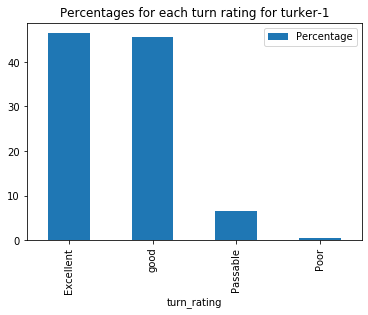

In [74]:
comp.plot.bar(x='turn_rating', title="Percentages for each turn rating for turker-1")  ### Barplot showing percentages for each type of turn_rating for turk 1

In [31]:
# creating data frames for percentages for turn rating for turker 2
list1= ['Excellent','good','Passable','Poor']
list2=[(b['Excellent']/len(agent2))*100,
(b['Good']/len(agent2))*100,
(b['Passable']/len(agent2))*100,
(b['Poor']/len(agent2))*100]

comp2=pd.DataFrame({'turn_rating':list1,'Percentage':list2})
comp2

,turn_rating,Percentage
0,Excellent,50.425099
1,good,43.948988
2,Passable,4.728114
3,Poor,0.236904


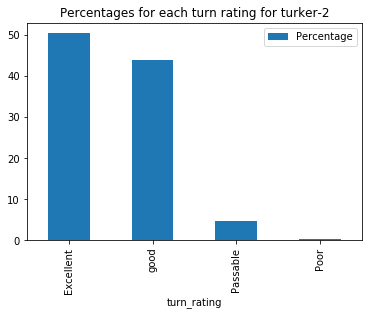

In [75]:
comp2.plot.bar(x='turn_rating', title="Percentages for each turn rating for turker-2")  ### Barplot showing percentages for each type of turn_rating for turk 2

In [33]:
# creating data frames for percentages for turn rating for turker 1
list1=agent1.sentiment.unique()
list2=[(c[0]/len(agent1))*100,
(c[1]/len(agent1))*100,
(c[2]/len(agent1))*100,
(c[3]/len(agent1))*100,
(c[4]/len(agent1))*100,
(c[5]/len(agent1))*100,
(c[6]/len(agent1))*100,
(c[7]/len(agent1))*100]

comp3=pd.DataFrame({'sentiment':list1,'Percentage':list2})
comp3

,sentiment,Percentage
0,Curious to dive deeper,45.324167
1,Neutral,20.309888
2,Surprised,15.842273
3,Happy,15.577456
4,Sad,1.292929
5,Disgusted,0.711371
6,Fearful,0.503671
7,Angry,0.438246


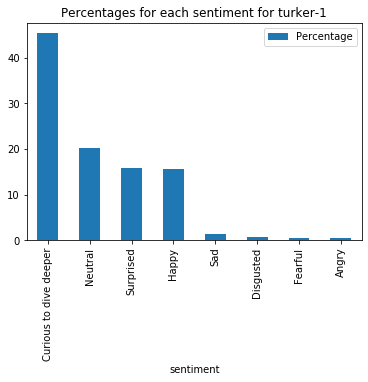

In [76]:
comp3.plot.bar(x='sentiment',title="Percentages for each sentiment for turker-1")   ### Barplot showing percentages for each type of sentiment for turk 1

In [35]:
# creating data frames for percentages for turn rating for turker 2
list1=agent2.sentiment.unique()
list2=[(d[0]/len(agent2))*100,
(d[1]/len(agent2))*100,
(d[2]/len(agent2))*100,
(d[3]/len(agent2))*100,
(d[4]/len(agent2))*100,
(d[5]/len(agent2))*100,
(d[6]/len(agent2))*100,
(d[7]/len(agent2))*100]

comp4=pd.DataFrame({'sentiment':list1,'Percentage':list2})
comp4

,sentiment,Percentage
0,Curious to dive deeper,40.523845
1,Happy,23.722490
2,Neutral,16.791392
3,Surprised,15.708719
4,Sad,1.398176
5,Disgusted,0.788204
6,Fearful,0.577868
7,Angry,0.489306


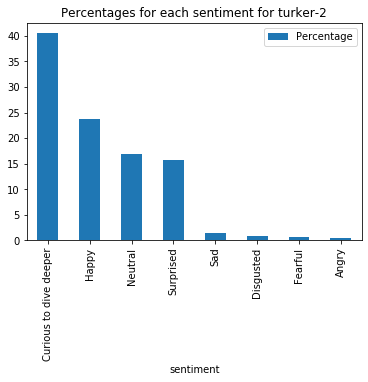

In [77]:
comp4.plot.bar(x='sentiment',title="Percentages for each sentiment for turker-2")   ### Barplot showing percentages for each type of sentiment for turk 2

TEST FILE

In [39]:
#### Segregating data for separate agents 

agent_test1 = test_clean.loc[test_clean['agent'] == 'agent_1']
agent_test2 = test_clean.loc[test_clean['agent'] == 'agent_2']

In [40]:
agent_test1.loc[agent_test1['turn_rating']=='Excellent'].count()

message        2828
sentiment      2828
agent          2828
turn_rating    2828
dtype: int64

In [41]:
agent_test1.sentiment.unique()

array(['Happy', 'Curious to dive deeper', 'Neutral', 'Surprised', 'Sad',
       'Disgusted', 'Angry', 'Fearful'], dtype=object)

In [42]:
len(agent_test1)

5962

In [43]:
len(agent_test2)

5583

In [44]:
len(agent_test1)-len(agent_test2)

379

In [45]:
##### Calculating the turn rating and sentiments for agent 1 and agent 2 in test file
a_1=agent_test1.turn_rating.value_counts()
b_1=agent_test2.turn_rating.value_counts()
c_1=agent_test1.sentiment.value_counts()
d_1=agent_test2.sentiment.value_counts()

In [46]:
#percentages turker 1 (test)
excellent3=(a_1['Excellent']/len(agent_test1))*100
good3=(a_1['Good']/len(agent_test1))*100
Passable3=(a_1['Passable']/len(agent_test1))*100
Poor3=(a_1['Poor']/len(agent_test1))*100

print(excellent3)
print(good3)
print(Passable3)
print(Poor3)

47.43374706474338
45.27004360952701
6.273062730627306
0.3522307950352231


In [47]:
#percentages of turker 2 (test)
excellent4=(b_1['Excellent']/len(agent_test2))*100
good4=(b_1['Good']/len(agent_test2))*100
Passable4=(b_1['Passable']/len(agent_test2))*100
Poor4=(b_1['Poor']/len(agent_test2))*100

print(excellent2)
print(good2)
print(Passable2)
print(Poor2)

50.425098525439495
43.94898817694726
4.728114068104326
0.2369038657397157


In [48]:
# creating data frames for percentages for turn rating for turker 1
list_test1= ['Excellent','good','Passable','Poor']
list_test2=[(a['Excellent']/len(agent_test1))*100,
(a['Good']/len(agent_test1))*100,
(a['Passable']/len(agent_test1))*100,
(a['Poor']/len(agent_test1))*100]

comp_test=pd.DataFrame({'turn_rating':list_test1,'Percentage':list_test2})
comp_test

,turn_rating,Percentage
0,Excellent,751.308286
1,good,738.175109
2,Passable,105.887286
3,Poor,5.719557


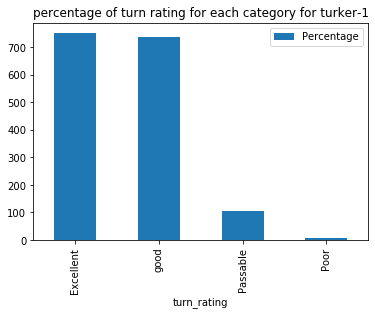

In [80]:
comp_test.plot.bar(x='turn_rating',title='percentage of turn rating for each category for turker-1')  ### Barplot showing percentages for each type of turn_rating for turk 1 (test)

In [50]:
# creating data frames for percentages for turn rating for turker 2
list_test1= ['Excellent','good','Passable','Poor']
list_test2=[(b_1['Excellent']/len(agent_test2))*100,
(b_1['Good']/len(agent_test2))*100,
(b_1['Passable']/len(agent_test2))*100,
(b_1['Poor']/len(agent_test2))*100]

comp_test2=pd.DataFrame({'turn_rating':list_test1,'Percentage':list_test2})
comp_test2

,turn_rating,Percentage
0,Excellent,52.856887
1,good,42.342826
2,Passable,4.137560
3,Poor,0.107469


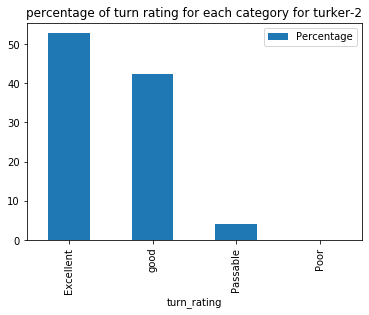

In [81]:
comp_test2.plot.bar(x='turn_rating',title='percentage of turn rating for each category for turker-2') ### Barplot showing percentages for each type of turn_rating for turk 2 (test)

In [82]:
# creating data frames for percentages for turn rating for turker 1
list_test1=agent_test1.sentiment.unique()
list_test2=[(c_1[0]/len(agent_test1))*100,
(c_1[1]/len(agent_test1))*100,
(c_1[2]/len(agent_test1))*100,
(c_1[3]/len(agent_test1))*100,
(c_1[4]/len(agent_test1))*100,
(c_1[5]/len(agent_test1))*100,
(c_1[6]/len(agent_test1))*100,
(c_1[7]/len(agent_test1))*100]

comp_test3=pd.DataFrame({'sentiment':list_test1,'Percentage':list_test2})
comp_test3

,sentiment,Percentage
0,Happy,42.569608
1,Curious to dive deeper,20.546796
2,Neutral,18.383093
3,Surprised,16.252935
4,Sad,1.039919
5,Disgusted,0.519960
6,Angry,0.352231
7,Fearful,0.335458


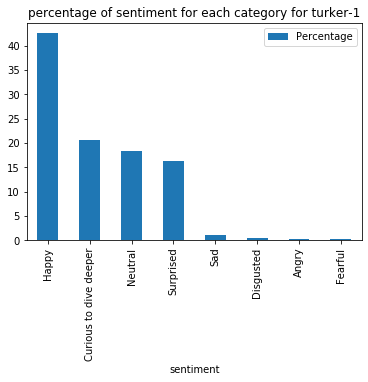

In [83]:
comp_test3.plot.bar(x='sentiment',title='percentage of sentiment for each category for turker-1') ### Barplot showing percentages for each type of sentiment for turk 1 (test)

In [54]:
list_test1=agent_test2.sentiment.unique()
list_test2=[(d_1[0]/len(agent_test2))*100,
(d_1[1]/len(agent_test2))*100,
(d_1[2]/len(agent_test2))*100,
(d_1[3]/len(agent_test2))*100,
(d_1[4]/len(agent_test2))*100,
(d_1[5]/len(agent_test2))*100,
(d_1[6]/len(agent_test2))*100,
(d_1[7]/len(agent_test2))*100]

comp_test4=pd.DataFrame({'sentiment':list_test1,'Percentage':list_test2})
comp_test4

,sentiment,Percentage
0,Happy,40.014329
1,Neutral,22.013255
2,Surprised,19.254881
3,Curious to dive deeper,16.854738
4,Angry,0.806018
5,Sad,0.429876
6,Fearful,0.358230
7,Disgusted,0.268673


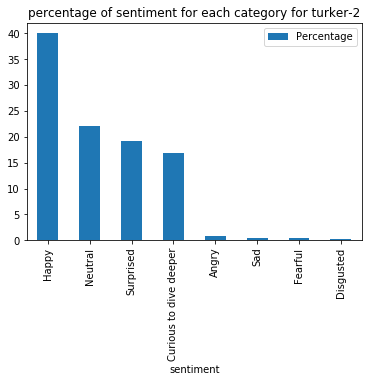

In [84]:
comp_test4.plot.bar(x='sentiment',title='percentage of sentiment for each category for turker-2')  ### Barplot showing percentages for each type of sentiment for turk 2 (test)

NLP

In [60]:
#########  Creating Functions to remove unwanted words, punctuation, and lemmatize the messages 

def remove_punct (text):
    no_punc = [c for c in text if c.isalpha()]
    return no_punc

stop_words = set(stopwords.words('english')) 
def stop(text):
    words = [w for w in text if w not in stop_words]
    return words

def lemma(text):
    lem = " ".join([WordNetLemmatizer().lemmatize(i) for i in text])
    return lem

In [61]:
#######  Tokenizing and removing stop words, punctuations, and lemmatizing the messages in train file

tokenizer = RegexpTokenizer(r'\w+')
train_clean["message"] = train_clean["message"].apply(lambda x: tokenizer.tokenize(x))

train_clean["message"] = train_clean["message"].apply(lambda x:remove_punct(x))

train_clean["message"] = train_clean["message"].apply(lambda x:stop(x))

train_clean["message"] = train_clean["message"].apply(lambda x: lemma(x))
print(train_clean.head())

                                             message               sentiment  \
0                           Are fan Google Microsoft  Curious to dive deeper   
1  Both excellent technology helpful many way For...  Curious to dive deeper   
2  I huge fan Google I use lot I I think monopoly...  Curious to dive deeper   
3  Google provides online related service product...  Curious to dive deeper   
4    Yeah service good I fan intrusive personal life  Curious to dive deeper   

     agent turn_rating  
0  agent_1        Good  
1  agent_2   Excellent  
2  agent_1        Good  
3  agent_2   Excellent  
4  agent_1        Good  


In [62]:
#######  Tokenizing and removing stop words, punctuations, and lemmatizing the sentiments in train file

train_clean["sentiment"] = train_clean["sentiment"].apply(lambda x: tokenizer.tokenize(x))

train_clean["sentiment"] = train_clean["sentiment"].apply(lambda x:remove_punct(x))

train_clean["sentiment"] = train_clean["sentiment"].apply(lambda x:stop(x))

train_clean["sentiment"] = train_clean["sentiment"].apply(lambda x: lemma(x))
print(train_clean.head())

                                             message            sentiment  \
0                           Are fan Google Microsoft  Curious dive deeper   
1  Both excellent technology helpful many way For...  Curious dive deeper   
2  I huge fan Google I use lot I I think monopoly...  Curious dive deeper   
3  Google provides online related service product...  Curious dive deeper   
4    Yeah service good I fan intrusive personal life  Curious dive deeper   

     agent turn_rating  
0  agent_1        Good  
1  agent_2   Excellent  
2  agent_1        Good  
3  agent_2   Excellent  
4  agent_1        Good  


In [63]:
#######  Tokenizing and removing stop words, punctuations, and lemmatizing the messages in test file

test_clean["message"] = test_clean["message"].apply(lambda x: tokenizer.tokenize(x))

test_clean["message"] = test_clean["message"].apply(lambda x:remove_punct(x))

test_clean["message"] = test_clean["message"].apply(lambda x:stop(x))

test_clean["message"] = test_clean["message"].apply(lambda x: lemma(x))
print(test_clean.head())

                                             message               sentiment  \
0                           Hello Do like rock music                   Happy   
1                 Hi I love rock music I think since                   Happy   
2  Yeah definitely classic great genre White snak...                   Happy   
3                     I know The list wikipedia page                 Neutral   
4  I wonder many people ended leaving joining ban...  Curious to dive deeper   

     agent turn_rating  
0  agent_1        Good  
1  agent_2   Excellent  
2  agent_1        Good  
3  agent_2   Excellent  
4  agent_1        Good  


In [64]:
#######  Tokenizing and removing stop words, punctuations, and lemmatizing the sentiments in test file

test_clean["sentiment"] = test_clean["sentiment"].apply(lambda x: tokenizer.tokenize(x))

test_clean["sentiment"] = test_clean["sentiment"].apply(lambda x:remove_punct(x))

test_clean["sentiment"] = test_clean["sentiment"].apply(lambda x:stop(x))

test_clean["sentiment"] = test_clean["sentiment"].apply(lambda x: lemma(x))
print(test_clean.head())

                                             message            sentiment  \
0                           Hello Do like rock music                Happy   
1                 Hi I love rock music I think since                Happy   
2  Yeah definitely classic great genre White snak...                Happy   
3                     I know The list wikipedia page              Neutral   
4  I wonder many people ended leaving joining ban...  Curious dive deeper   

     agent turn_rating  
0  agent_1        Good  
1  agent_2   Excellent  
2  agent_1        Good  
3  agent_2   Excellent  
4  agent_1        Good  


In [65]:
#count number of punctuation in text

train_clean['message_len'] = train_clean['message'].apply(lambda x: len(x) - x.count(" "))

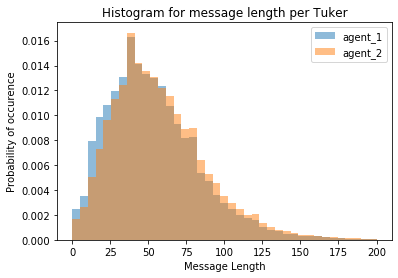

In [67]:
######  Histogram for message length per Tuker
import matplotlib.pyplot as plt
bins = np.linspace(0, 200, 40)
plt.hist(train_clean[train_clean['agent']=='agent_1']['message_len'], bins, alpha=0.5, normed=True, label='agent_1')
plt.hist(train_clean[train_clean['agent']=='agent_2']['message_len'], bins, alpha=0.5, normed=True, label='agent_2')
plt.xlabel("Message Length")
plt.ylabel("Probability of occurence")
plt.title("Histogram for message length per Tuker")
plt.legend(loc='upper right')
plt.show()

In [68]:
########  Applying TFIDF on the messages of both train and test files

tfidf = TfidfVectorizer()
df_vector_1 = tfidf.fit_transform(train_clean['message'].values)
df_vector_test_1 = tfidf.transform(test_clean['message'])
print(df_vector_1.shape)
print(df_vector_test_1.shape)

(186625, 32438)
(11545, 32438)


In [69]:
########## Applying Naive Bayes algorithm with turn_rating as the target

clf = MultinomialNB().fit(df_vector_1, train_clean['turn_rating'])
predicted = clf.predict(df_vector_test_1)
print(accuracy_score(test_clean['turn_rating'],predicted))

0.4949328713728887


In [70]:
#### Confusion for predictions using Naive Bayes on turn_rating as target 

confusion_matrix(test_clean['turn_rating'], predicted)

array([[3606, 2171,    0,    2,    0],
       [2955, 2108,    0,    0,    0],
       [  45,   26,    0,    0,    0],
       [ 351,  254,    0,    0,    0],
       [  14,   13,    0,    0,    0]], dtype=int64)

In [96]:
print(classification_report(test_clean['turn_rating'], predicted))

              precision    recall  f1-score   support

   Excellent       0.52      0.62      0.57      5779
        Good       0.46      0.42      0.44      5063
    Not Good       0.00      0.00      0.00        71
    Passable       0.00      0.00      0.00       605
        Poor       0.00      0.00      0.00        27

    accuracy                           0.49     11545
   macro avg       0.20      0.21      0.20     11545
weighted avg       0.46      0.49      0.48     11545



In [98]:
########## Applying Naive Bayes algorithm with sentiment as the target

clf_1 = MultinomialNB().fit(df_vector_1, train_clean['sentiment'])
predicted_1 = clf_1.predict(df_vector_test_1)
print(accuracy_score(test_clean['sentiment'],predicted_1))

0.4312689475963621


In [99]:
#### Confusion for predictions using Naive Bayes on sentiment as target

confusion_matrix(test_clean['sentiment'],predicted_1)

array([[   0,   36,    0,    0,    0,    5,    0,    0],
       [   0, 4521,    0,    0,   45,  165,    0,   41],
       [   0,   45,    0,    0,    0,   10,    0,    0],
       [   0,   34,    0,    0,    0,    1,    0,    0],
       [   0, 1769,    0,    0,  122,  134,    0,   12],
       [   0, 2086,    0,    0,   65,  282,    0,   21],
       [   0,  100,    0,    0,    0,    6,    0,    1],
       [   0, 1886,    0,    0,   26,   78,    0,   54]], dtype=int64)

In [100]:
print(classification_report(test_clean['sentiment'], predicted_1))

                     precision    recall  f1-score   support

              Angry       0.00      0.00      0.00        41
Curious dive deeper       0.43      0.95      0.59      4772
          Disgusted       0.00      0.00      0.00        55
            Fearful       0.00      0.00      0.00        35
              Happy       0.47      0.06      0.11      2037
            Neutral       0.41      0.11      0.18      2454
                Sad       0.00      0.00      0.00       107
          Surprised       0.42      0.03      0.05      2044

           accuracy                           0.43     11545
          macro avg       0.22      0.14      0.12     11545
       weighted avg       0.42      0.43      0.31     11545



In [101]:
########## Applying Random Forest Classifier algorithm with turn_rating as the target

RF_clf = RandomForestClassifier(n_estimators=10)
RF_clf.fit(df_vector_1, train_clean['turn_rating'])
predicted_rf = RF_clf.predict(df_vector_test_1)
print(accuracy_score(test_clean['turn_rating'],predicted_rf))

0.4880034647033348


In [102]:
#### Confusion for predictions using Random Forest Classifier on turn_rating as target

confusion_matrix(test_clean['turn_rating'], predicted_rf)

array([[3528, 2234,    1,   16,    0],
       [2944, 2098,    0,   20,    1],
       [  41,   30,    0,    0,    0],
       [ 350,  246,    1,    8,    0],
       [   8,   18,    0,    1,    0]], dtype=int64)

In [103]:
print(classification_report(test_clean['turn_rating'], predicted_rf))

              precision    recall  f1-score   support

   Excellent       0.51      0.61      0.56      5779
        Good       0.45      0.41      0.43      5063
    Not Good       0.00      0.00      0.00        71
    Passable       0.18      0.01      0.02       605
        Poor       0.00      0.00      0.00        27

    accuracy                           0.49     11545
   macro avg       0.23      0.21      0.20     11545
weighted avg       0.47      0.49      0.47     11545



In [104]:
########## Applying Random Forest Classifier algorithm with sentiment as the target

RF_clf_1 = RandomForestClassifier(n_estimators=10)
RF_clf_1.fit(df_vector_1, train_clean['sentiment'])
predicted_rf_1 = RF_clf_1.predict(df_vector_test_1)
print(accuracy_score(test_clean['sentiment'],predicted_rf_1))

0.44963187527067994


In [105]:
#### Confusion for predictions using Random Forest Classifier on sentiment as target

confusion_matrix(test_clean['sentiment'], predicted_rf_1)

array([[   0,   31,    0,    0,    1,    6,    0,    3],
       [   1, 3952,    0,    0,  217,  440,    3,  159],
       [   0,   43,    0,    0,    2,    9,    0,    1],
       [   0,   23,    0,    0,    3,    8,    0,    1],
       [   0, 1313,    0,    0,  312,  307,    3,  102],
       [   2, 1552,    1,    0,  144,  655,    1,   99],
       [   0,   74,    0,    0,    8,   17,    4,    4],
       [   0, 1390,    0,    0,  130,  255,    1,  268]], dtype=int64)

In [106]:
print(classification_report(test_clean['sentiment'], predicted_rf_1))

                     precision    recall  f1-score   support

              Angry       0.00      0.00      0.00        41
Curious dive deeper       0.47      0.83      0.60      4772
          Disgusted       0.00      0.00      0.00        55
            Fearful       0.00      0.00      0.00        35
              Happy       0.38      0.15      0.22      2037
            Neutral       0.39      0.27      0.32      2454
                Sad       0.33      0.04      0.07       107
          Surprised       0.42      0.13      0.20      2044

           accuracy                           0.45     11545
          macro avg       0.25      0.18      0.18     11545
       weighted avg       0.42      0.45      0.39     11545

